In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis')
sys.path.append(str(Path.cwd().parent.parent)+'/lund-university-code/TimeSeriesAnalysis/')

In [2]:
import pandas as pd
import TimeSeriesAnalysis.tsa_lth.analysis as analysis
import TimeSeriesAnalysis.tsa_lth.modelling as modelling
import TimeSeriesAnalysis.tsa_lth.tests as tests
from TimeSeriesAnalysis.tsa_lth.tools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pylab
import datetime as dt
import matplotlib.dates as mdates

In [7]:
def getARMA(data, A=0, C=0):
    A_free=A
    C_free=C
    model = modelling.PEM(data, A=A, C=C)
    if isinstance(A, int):
        A_free = [1]*(A+1)
    if isinstance(C, int):
        C_free = [1]*(C+1)
    model.set_free_params(A_free=A_free, C_free=C_free)
    model_fitted = model.fit(method='LS', bh=False)
    model_fitted.summary()
    return model_fitted

def checkNormal(data, remove=False, title=None):
    if remove:
        data = data[remove:]
    tests.check_if_normal(data)
    stats.probplot(data, dist="norm", plot=pylab)
    # variable = [ i for i, j in locals().items() if j == data][0]
    if title:
        plt.title(title)
    pylab.show()
    
    
def analyzeARMA(x, A=0, C=0, noLags=50, titleStr=None, return_val=False, normal_test=True):
    model = getARMA(x, A=A, C=C)
    if isinstance(A, int): len_A = A
    else: len_A = len(A)
    if isinstance(C, int): len_C = C
    else: len_C = len(C)
    remove=max(len_A, len_C)
    res = model.resid
    acf_est, pacf_est = analysis.plotACFnPACF(res,noLags=noLags,titleStr=titleStr, return_val=True)
    tests.whiteness_test(res)
    if normal_test:
        checkNormal(acf_est, remove=remove, title='ACF')
        checkNormal(pacf_est, remove=remove, title='PACF')
    if return_val:
        return model, acf_est, pacf_est

## Recursive temperature modeling

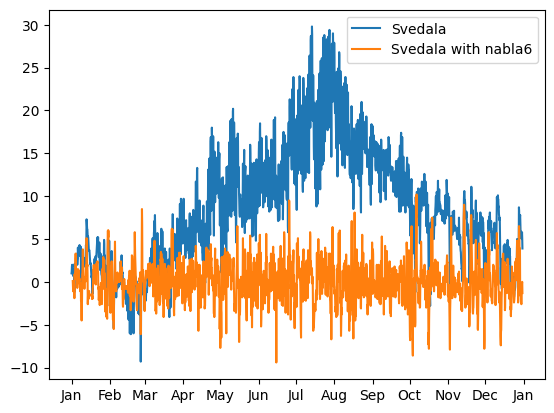

In [11]:
# Import data
svedala = analysis.mat2np('./data/svedala94.mat')
nabla_6 = [1] + [0]*5 + [-1]

# Filter nabla6
svedala_nabla6 = modelling.filter(nabla_6, 1, svedala, remove=True)

# Dates
start_date = dt.datetime(1994, 1, 1)
end_date = dt.datetime(1994, 12, 31)
n = len(svedala)
T = np.linspace(start_date.timestamp(), end_date.timestamp(), n)
T_dates = [dt.datetime.fromtimestamp(timestamp) for timestamp in T]

#Plot
plt.plot(T_dates, svedala, label='Svedala')
plt.plot(T_dates[len(nabla_6)-1:], svedala_nabla6, label='Svedala with nabla6')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.legend()
plt.show()

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 + 0.1538(±0.0347)·z⁻¹ - 0.5364(±0.0202)·z⁻²
C(z) = 1.0 + 1.0345(±0.0406)·z⁻¹ + 0.0468(±0.0392)·z⁻²

Polynomial orders: nA = 2    nC = 2
Number of free coefficients: 4
Fit to estimation data (NRMSE): 32.89%
FPE : 2.475  MSE : 2.466
AIC : 8169.384   BIC : 8192.136



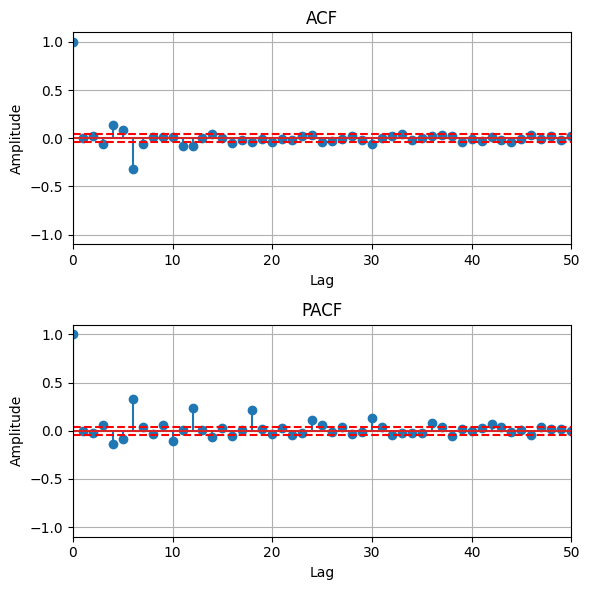

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 338.88 < 31.41)
  McLeod-Li test:        False (white if 176.07 < 31.41)
  Monti test:            False (white if 590.55 < 31.41)
  Sign change test:      True (white if 0.50 in [0.48,0.52])


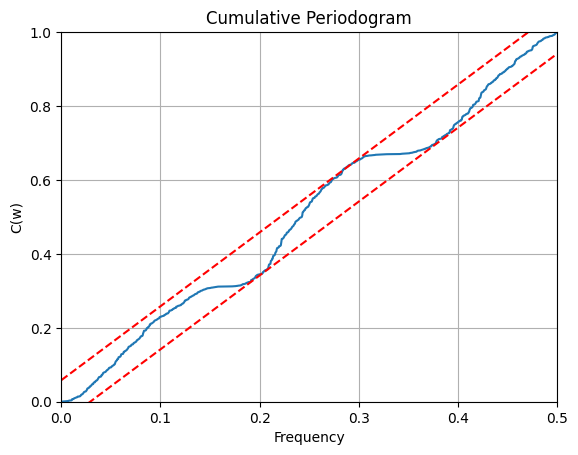

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


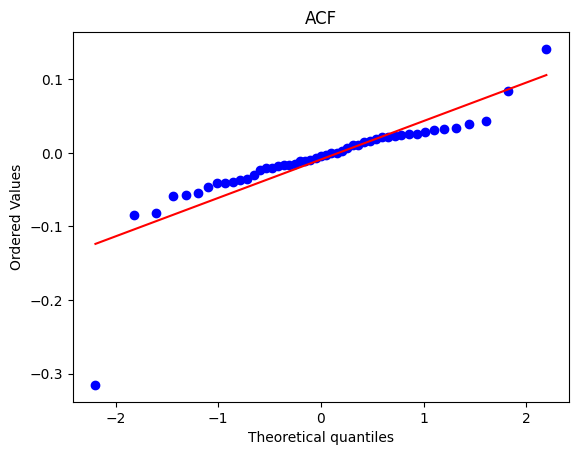

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


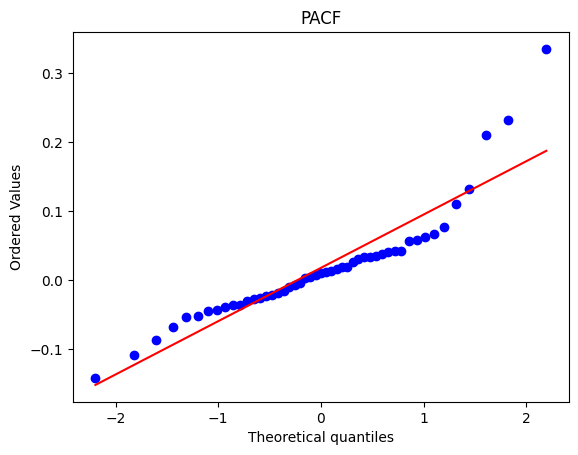

In [12]:
# Entire year
model, ACF, PACF = analyzeARMA(svedala_nabla6, A=2, C=2, return_val=True)

In [23]:
svedala_nabla6

array([ 0.1, -0.4, -1.1, ..., -0.1,  0. , -1.3])

array([ 0. ,  0. ,  0. , ..., -0.1,  0. , -1.3])

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 + 0.0423(±0.0717)·z⁻¹ - 0.5338(±0.0384)·z⁻²
C(z) = 1.0 + 1.0(±0.0839·z⁻¹ + 0.0098(±0.0816)·z⁻²

Polynomial orders: nA = 2    nC = 2
Number of free coefficients: 4
Fit to estimation data (NRMSE): 37.46%
FPE : 1.483  MSE : 1.461
AIC : 1719.559   BIC : 1736.666



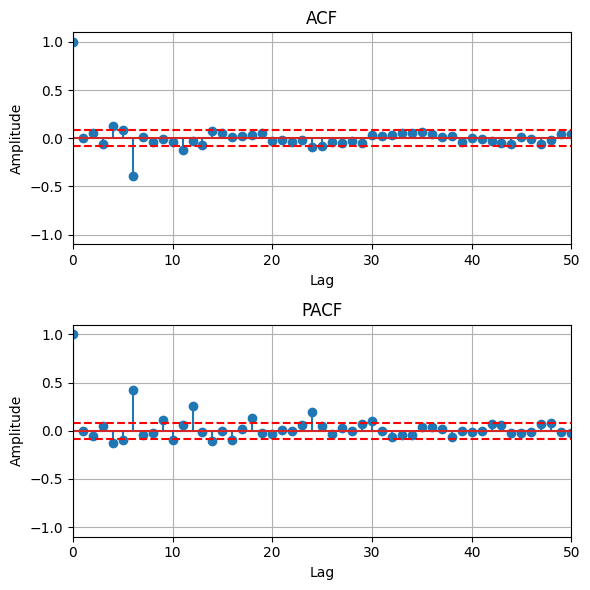

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 118.11 < 31.41)
  McLeod-Li test:        False (white if 98.01 < 31.41)
  Monti test:            False (white if 185.70 < 31.41)
  Sign change test:      True (white if 0.51 in [0.46,0.54])


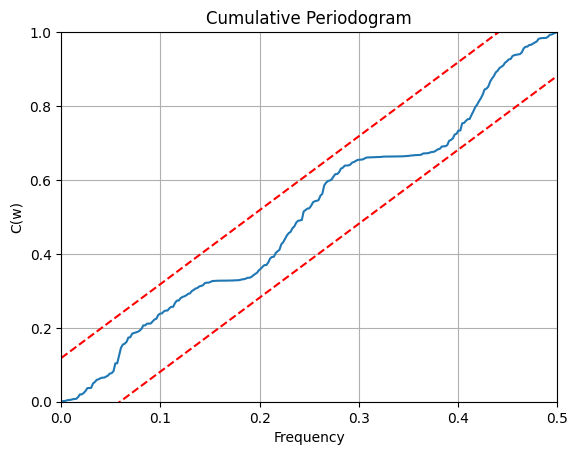

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


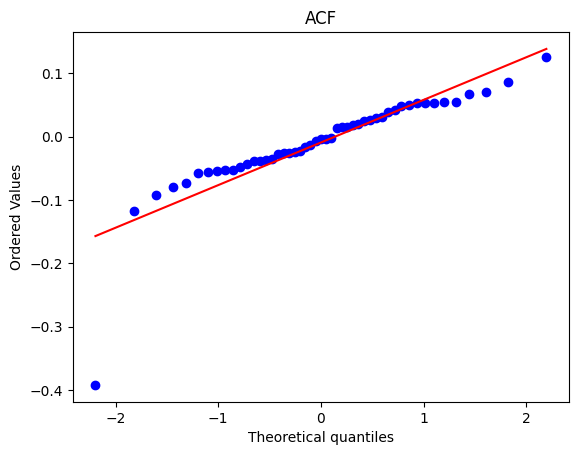

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


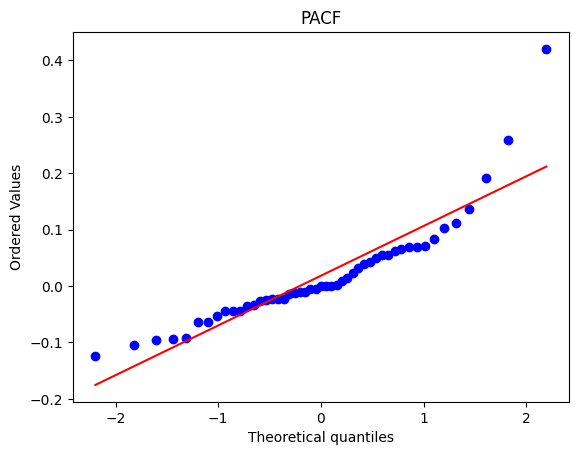

In [26]:
# January to March
df = pd.DataFrame({'Date': T_dates, 'Svedala94': svedala, 'Svedala94_nabla6': np.concatenate((np.array([0]*6), svedala_nabla6))})
start_date = dt.datetime(1994,1,1)
end_date = dt.datetime(1994,3,31)
y = df.loc[(df['Date'] > start_date) & (df['Date'] <= end_date)]['Svedala94_nabla6'].values
model_JM, ACF_JM, PACF_JM = analyzeARMA(y, A=2, C=2, return_val=True)

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 + 0.253(±0.0832)·z⁻¹ - 0.4576(±0.049)·z⁻²
C(z) = 1.0 + 1.0291(±0.0931)·z⁻¹ + 0.0398(±0.0907)·z⁻²

Polynomial orders: nA = 2    nC = 2
Number of free coefficients: 4
Fit to estimation data (NRMSE): 25.57%
FPE : 3.52  MSE : 3.468
AIC : 2236.534   BIC : 2253.745



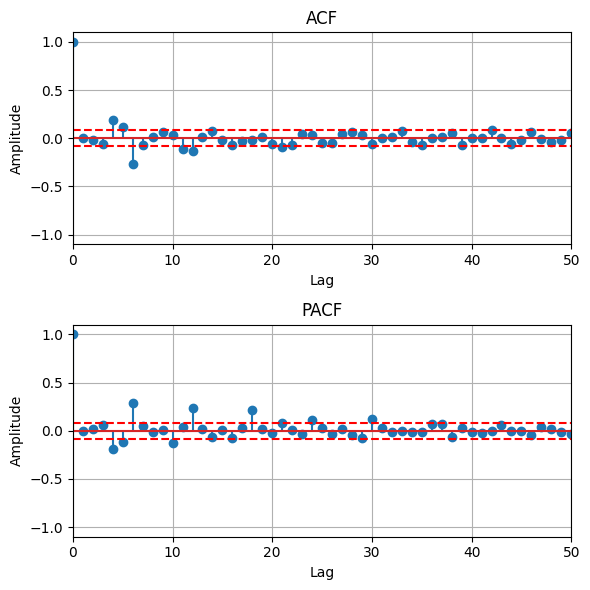

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 101.50 < 31.41)
  McLeod-Li test:        True (white if 29.88 < 31.41)
  Monti test:            False (white if 149.06 < 31.41)
  Sign change test:      True (white if 0.52 in [0.46,0.54])


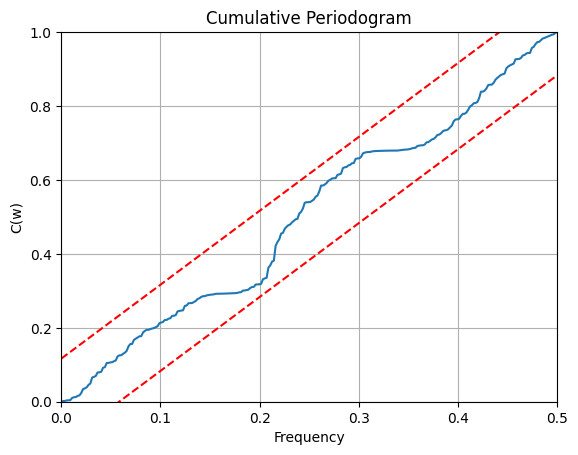

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


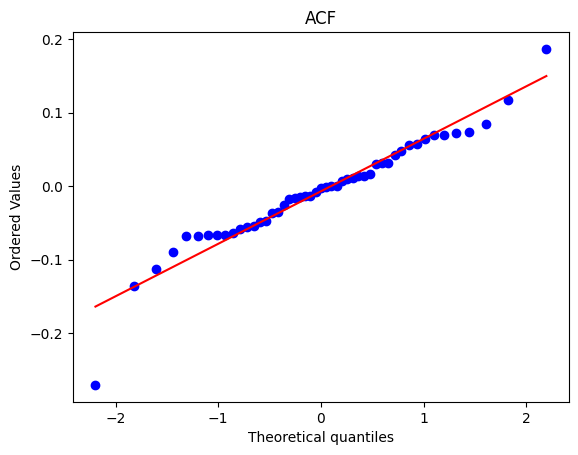

The D'Agostino-Pearson K2 test indicates that the data is NOT normal distributed.


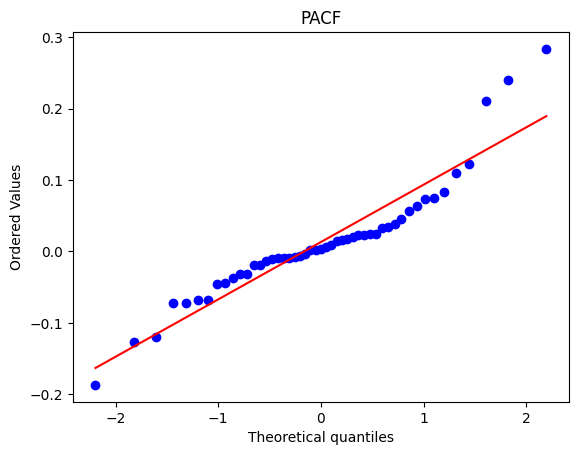

In [27]:
start_date = dt.datetime(1994,6,1)
end_date = dt.datetime(1994,8,31)
y = df.loc[(df['Date'] > start_date) & (df['Date'] <= end_date)]['Svedala94_nabla6'].values
model_JA, ACF_JA, PACF_JA =  analyzeARMA(y, A=2, C=2, return_val=True)

In [28]:
print(f'model parameters for whole year: A={model.A}, B={model.C}')
print(f'model parameters for Jan-Mar: A={model_JM.A}, B={model_JM.C}')
print(f'model parameters for Jul-Aug: A={model_JA.A}, B={model_JA.C}')

model parameters for whole year: A=[ 1.          0.1537826  -0.53641466], B=[1.         1.03447593 0.04678918]
model parameters for Jan-Mar: A=[ 1.          0.04230356 -0.53383037], B=[1.         0.99996569 0.00983809]
model parameters for Jul-Aug: A=[ 1.          0.25298435 -0.45761088], B=[1.         1.02906836 0.03982026]


Can be observed that there is a big difference in the parameters of the A(z) polynomials

In [126]:
init_A

array([ 0.06682092, -0.54766157])

In [33]:
np.array([init_A, init_C]).reshape(-1, 1)

array([[-1.662 ],
       [ 0.7012],
       [-0.8374],
       [-0.1075]])

In [39]:
ARest[4:,:]

array([[-0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [-1.        ,  1.34057421, -1.12976772],
       ...,
       [-0.74882106, -0.84879568,  0.74077666],
       [-0.74720636, -0.85192294,  0.7414164 ],
       [-0.72816472, -0.87071501,  0.74167128]])

In [34]:
# init_A = model_JM.A[1:]
# init_C = model_JM.C[1:]
init_A = [1,-1.662, .7012]
init_C = [1,-.8374, -.1075]
ARest, MAeset, yhat = modelling.recursiveARMA(svedala_nabla6, 3,3, forgetting_factor=.99, theta_guess=[init_A,init_C])

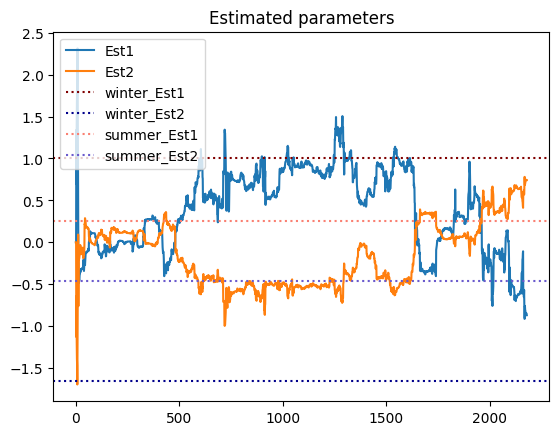

In [38]:
plt.plot(ARest[4:,1:], label=['Est1','Est2'])
plt.axhline(y = init_A[0], color = 'maroon', linestyle = 'dotted', label='winter_Est1') 
plt.axhline(y = init_A[1], color = 'darkblue', linestyle = 'dotted', label='winter_Est2') 
plt.axhline(y = model_JA.A[1], color = 'salmon', linestyle = 'dotted', label='summer_Est1') 
plt.axhline(y = model_JA.A[2], color = 'slateblue', linestyle = 'dotted', label='summer_Est2') 
plt.legend()
plt.title('Estimated parameters')
plt.show()

Yes, it is highly likely that winter and summer are different processes which 

## Recursive temperature modeling, again